# Praca domowa 6

***Renata Rólkiewicz***

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
from sklearn import cluster, datasets, mixture, preprocessing
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabaz_score
import warnings
warnings.filterwarnings('ignore')

## Zbiór danych
---
Jest to zbiór danych w wymiarze $R^3$ . Obserwacje nie są przypisane do żadnej klasy. Zbiór zawiera 1000 obserwacji.

In [2]:
data_raw = pd.read_csv('clustering_R3.csv')
data = data_raw.copy()
data.head(10)

,X1,X2,X3
0,152.077986,197.910402,1.095707
1,145.520487,202.128032,2.738826
2,155.441273,198.122696,0.640457
3,150.389105,206.808383,0.686486
4,149.863221,205.417527,3.555814
5,142.410820,208.958082,3.383849
6,150.612020,201.265581,1.171160
7,146.857036,205.544996,2.621157
8,151.393323,202.981200,1.015493
9,153.938260,202.139725,2.696769


In [3]:
data.shape

(1000, 3)

In [4]:
data.describe()

,X1,X2,X3
count,1000.000000,1000.000000,1000.000000
mean,240.181036,154.937365,5.454947
std,115.556334,41.964161,4.793973
min,38.516347,87.376621,0.125057
25%,148.801776,104.853322,1.806255
50%,231.754437,151.846118,3.430892
75%,350.277958,198.367658,8.287805
max,399.930758,213.917568,24.537806


**Zobaczmy jak punkty rozkładają się w przestrzeni $R^3$.**

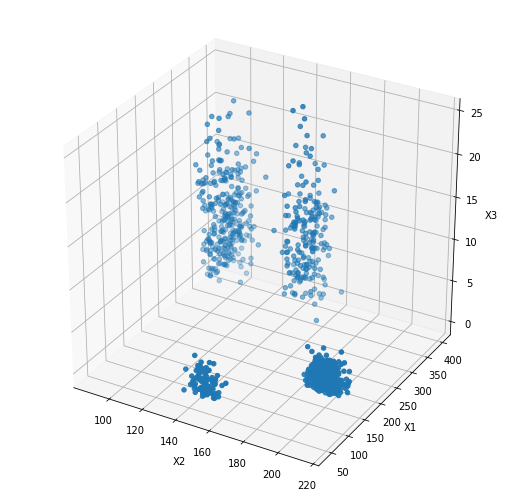

In [5]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(9, 9))
ax = plt.axes(projection='3d')
ax.scatter(data_raw['X2'], data_raw['X1'], data_raw['X3'], s=20)

ax.set_xlabel('X2')
ax.set_ylabel('X1')
ax.set_zlabel('X3')

plt.show()

Widzimy znaczące rozdzielenie na 4 grupy.

## Przygotowanie danych
---

Aby lepiej przygotować nasze dane do klasteryzacji, wykonujemy skalowanie danych za pomocą `StandardScaler`.

### StandardScaler

In [6]:
std_scale = preprocessing.StandardScaler().fit(data.iloc[:,[0,1,2]])
data = pd.DataFrame(std_scale.transform(data.iloc[:,[0,1,2]]), columns=['X1', 'X2', 'X3'])
data.head()

,X1,X2,X3
0,-0.762807,1.024554,-0.909772
1,-0.819582,1.125110,-0.566853
2,-0.733687,1.029615,-1.004782
3,-0.777429,1.236698,-0.995176
4,-0.781982,1.203537,-0.396348


### Rozkłady

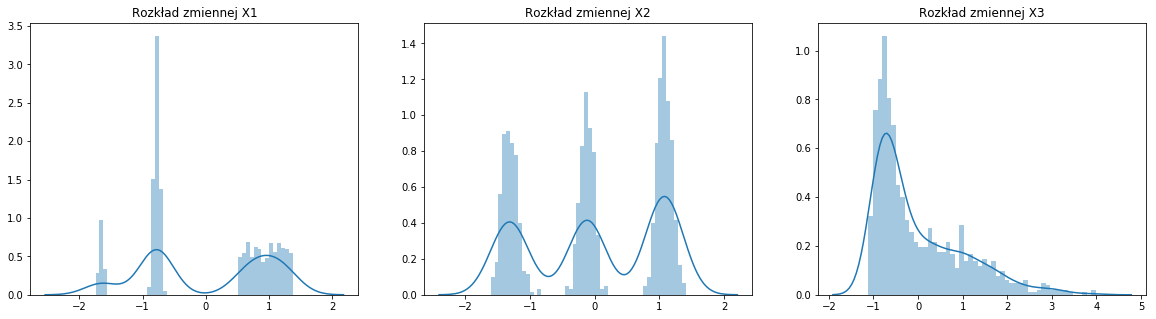

In [7]:
plt.subplots(1,3, figsize=(20, 5))
plt.subplot(1,3,1)
sns.distplot(data.X1, bins=50).set(xlabel="", title='Rozkład zmiennej X1')
plt.subplot(1,3,2)
sns.distplot(data.X2, bins=50).set(xlabel="", title='Rozkład zmiennej X2')
plt.subplot(1,3,3)
sns.distplot(data.X3, bins=50).set(xlabel="", title='Rozkład zmiennej X3')
plt.show()

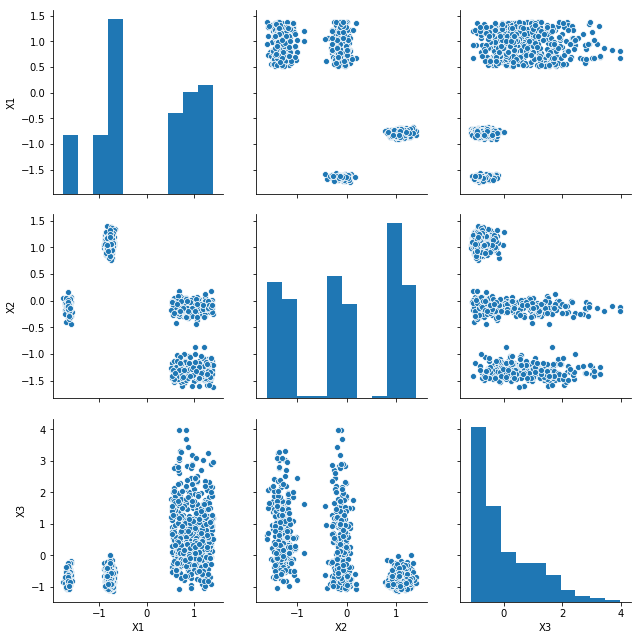

In [8]:
sns.pairplot(data, height=3)
plt.show()

## Użyte metody i miary
---

Metody:
- K-means
- Hierarchiczne metody z połączeniem średnim, pojedynczym i warda (average, single, ward)

Miary:
- Współczynnik Silhouette - średnia z wartości współczynnika dla wszystkich obserwacji. Współczynnik określa jak dobrze "pasuje" dana obserwacja w klastrze korzystając ze średniej odległości od innych obserwacji w przypisanym klastrze i średniej odległości od obserwacji z innego, najbliższego klastra. Im większa wartość tego współczynnika tym lepiej
- Indeks Daviesa–Bouldina - wyliczenie średniej wartości podobieństwa między grupami. Im mniejsze podobieństwo między grupami tym lepiej, a więc zależy nam na jak najmniejszej wartości tego indeksu
- Indeks Calińskiego-Harabasza - obliczany na podstawie macierzy kowariancji międzyklastrowej i wewnątrzklastrowej. Im większa wartość tym lepiej.

## 1 metoda: K-means
---

###  Optymalna liczba klastrów

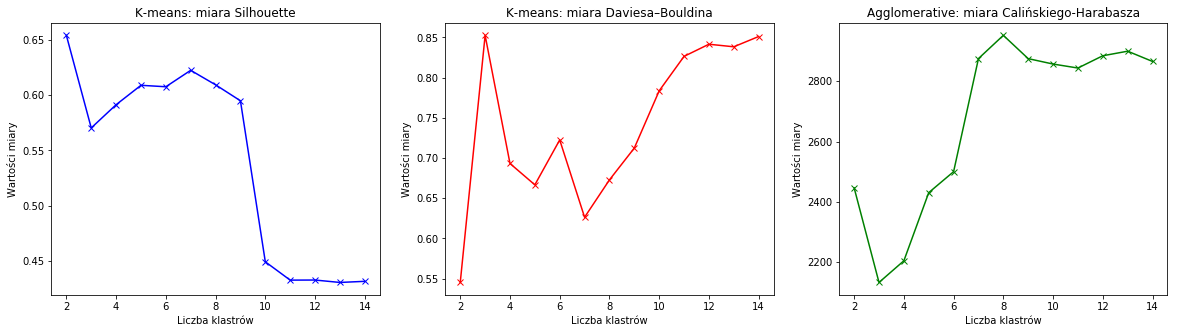

In [9]:
cluster_num_seq = range(2, 15)
scores_ss1 = [] 
scores_db1 = []
scores_ch1 = []

for k in range(2,15):
    labels = KMeans(n_clusters=k, max_iter=20).fit_predict(data)
    score_ss1 = silhouette_score(data,labels)
    scores_ss1.append(score_ss1)
    score_db1 = davies_bouldin_score(data,labels)
    scores_db1.append(score_db1)
    score_ch1 = calinski_harabaz_score(data,labels)
    scores_ch1.append(score_ch1)

plt.subplots(1,3, figsize=(20, 5))
plt.subplot(1,3,1)
plt.plot(cluster_num_seq, scores_ss1, 'bx-')
plt.title("K-means: miara Silhouette")
plt.xlabel("Liczba klastrów")
plt.ylabel("Wartości miary")
plt.subplot(1,3,2)
plt.plot(cluster_num_seq, scores_db1, 'bx-', color='red')
plt.title("K-means: miara Daviesa–Bouldina")
plt.xlabel("Liczba klastrów")
plt.ylabel("Wartości miary")
plt.subplot(1,3,3)
plt.plot(cluster_num_seq, scores_ch1, 'bx-', c='green')
plt.title("Agglomerative: miara Calińskiego-Harabasza")
plt.xlabel("Liczba klastrów")
plt.ylabel("Wartości miary")
plt.show()

Miara Silhouette i Daviesa-Bouldina zdecydowanie wskazują liczbę klastrów równą 2, później 7. Miara Calińskiego-Harabasza natomiast wzskazuje na liczbę z zakresu 7-9. Biorąc pod uwagę wszystkie miary optymalna liczba klastrów to 2 lub 7.

### Przedstawienie podziału dla k=2

In [10]:
def KMeans_plot(data, n_clusters):
    kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=0).fit(data)
    k = kmeans.predict(data)
    data['k']=k
    sns.pairplot(data, height=2, hue='k',vars=['X1','X2','X3'])

    plt.figure(figsize=(8, 8))
    ax = plt.axes(projection='3d')
    ax.scatter(data['X2'], data['X1'], data['X3'], s=40,c=data['k'],cmap='plasma')

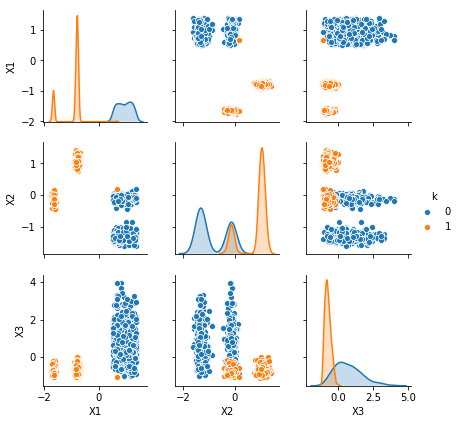

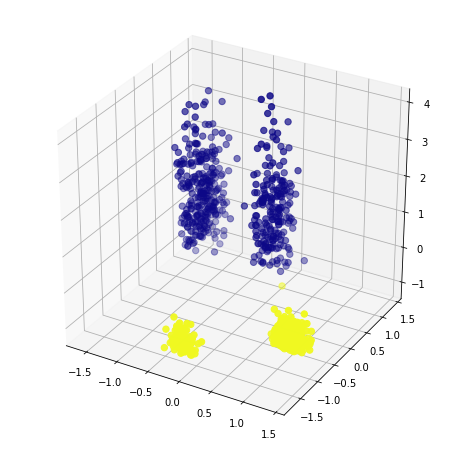

In [11]:
KMeans_plot(data,2)

### Przedstawienie podziału dla k=7

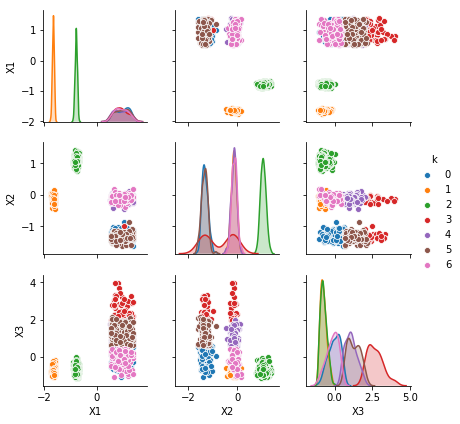

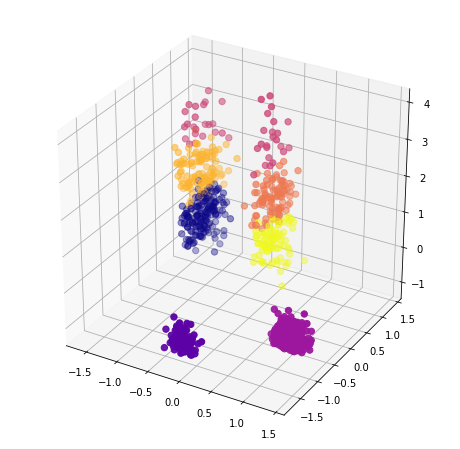

In [12]:
KMeans_plot(data,7)

## 2 metoda: Agglomerative
---

In [13]:
data=data.drop(columns=['k'])
def plot_metrics_agg(linkage,data):
    
    cluster_num_seq = range(2, 12)
    scores_ss2 = [] 
    scores_db2 = []
    scores_ch2 = []

    for k in range(2,12):
        labels2 = AgglomerativeClustering(n_clusters=k,linkage=linkage).fit_predict(data)
        score_ss = silhouette_score(data,labels2)
        scores_ss2.append(score_ss)
        score_db = davies_bouldin_score(data,labels2)
        scores_db2.append(score_db)
        score_ch = calinski_harabaz_score(data,labels2)
        scores_ch2.append(score_ch)
    
    plt.subplots(1,3, figsize=(20, 5))
    plt.subplot(1,3,1)
    plt.plot(cluster_num_seq, scores_ss2, 'bx-')
    plt.title('Agglomerative ('+linkage+'): miara Silhouette')
    plt.xlabel("Liczba klastrów")
    plt.ylabel("Wartości miary")
    plt.subplot(1,3,2)    
    plt.plot(cluster_num_seq, scores_db2, 'bx-', c='red')
    plt.title("Agglomerative ("+linkage+"): miara Daviesa–Bouldina")
    plt.xlabel("Liczba klastrów")
    plt.ylabel("Wartości miary")
    plt.subplot(1,3,3)    
    plt.plot(cluster_num_seq, scores_ch2, 'bx-', c='green')
    plt.title("Agglomerative ("+linkage+"): miara Calińskiego-Harabasza")
    plt.xlabel("Liczba klastrów")
    plt.ylabel("Wartości miary")
    plt.show()
    

### Ward

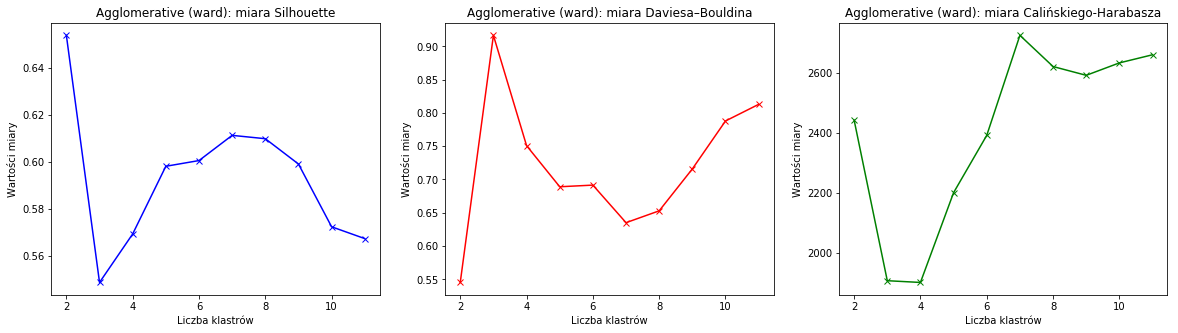

In [14]:
plot_metrics_agg('ward', data)

Dla miar Silhouette oraz Daviesa_Bouldina zdecydowanie wygrywa liczba klastrów równa 2. Dla miary Calińskiego-Harabasza lepszą wartość niż 2 osiąga liczba 7. Biorąc pod uwagę wszystkie trzy miary optymalny wybór to 2 lub 7.

### Average

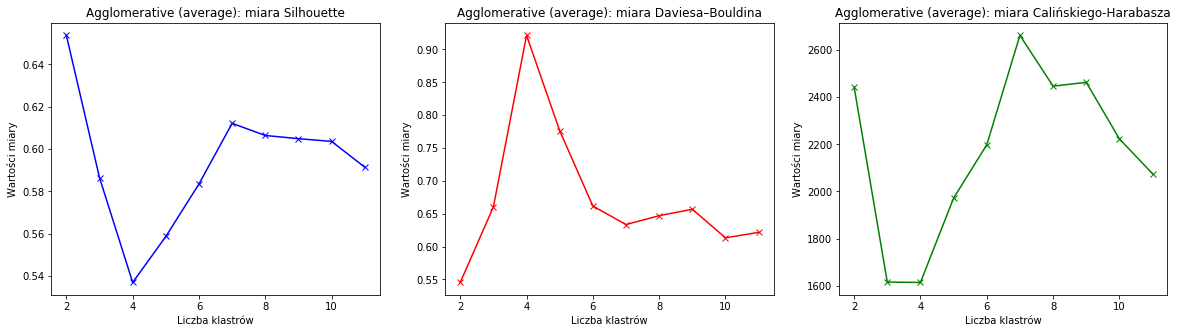

In [15]:
plot_metrics_agg('average',data)

Podobnie jak poprzednio, zdecydowanie dominuje liczba klastrów równa 2 a na drugim miejscy jest 7.

### Single

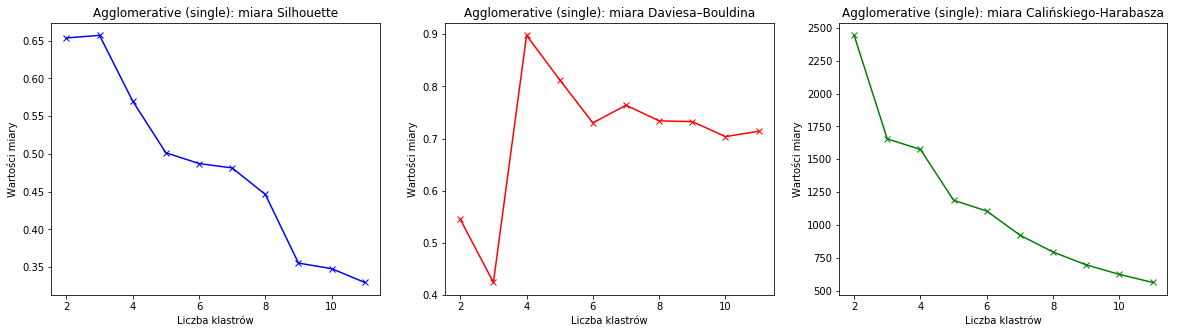

In [16]:
plot_metrics_agg('single',data)

Dla miar Silhouette i Daviesa-Bouldina tym razem minimalnie lepiej wypada liczba 3. Miara Calińskiego-Harabasza wskazuj jednak 2. Optymalnie zatem wybrać będzie 2 lub 3.

### Przedstawienie podziału ward, k=2

In [17]:
def Agglomerative_plot(data, n_clusters, linkage):
    agg = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage).fit(data)
    k = agg.fit_predict(data)
    
    data['k']=k
    sns.pairplot(data, height=2, hue='k',vars=['X1','X2','X3'])
    
    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes(projection='3d')
    ax.scatter(data['X2'], data['X1'], data['X3'], s=40, c=data['k'], cmap='plasma')
    plt.show()

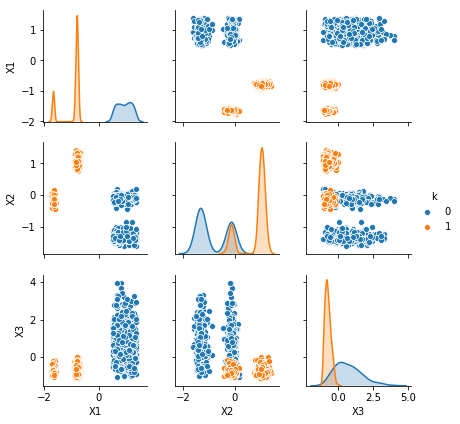

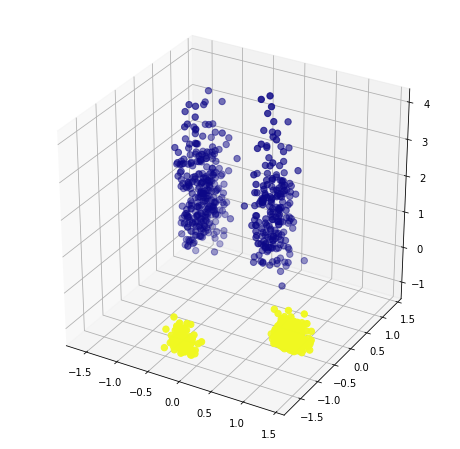

In [18]:
Agglomerative_plot(data,2,'ward')

### Przedstawienie podziału ward, k=2

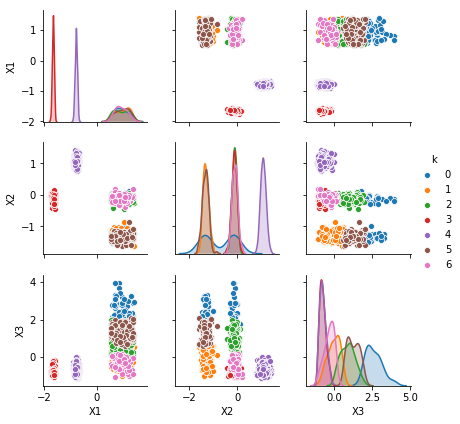

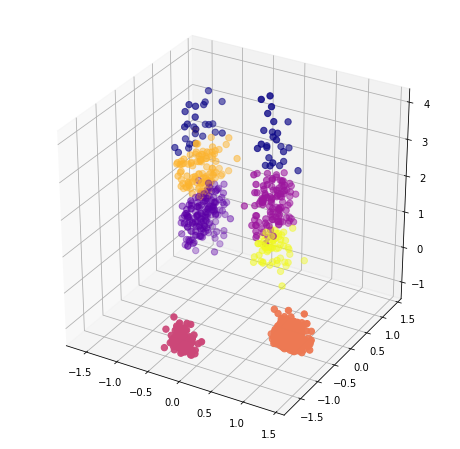

In [19]:
Agglomerative_plot(data,7,'ward')

### Przedstawienie podziału average, k=2

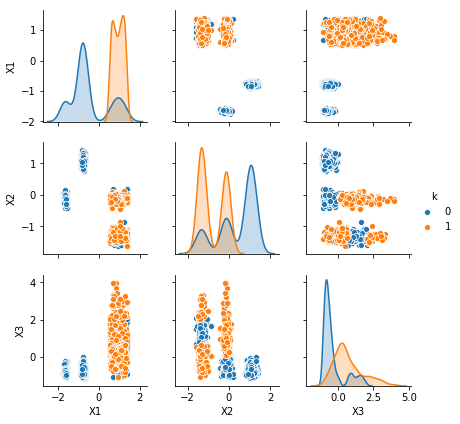

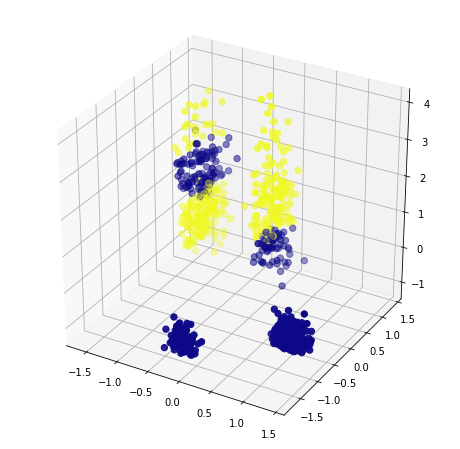

In [20]:
Agglomerative_plot(data,2,'average')

Ku zaskoczeniu, jest to kompletnie inny podział niż w przypadku K-means czy ward. Spójrzmy jeszcze z innej strony na ten podział.

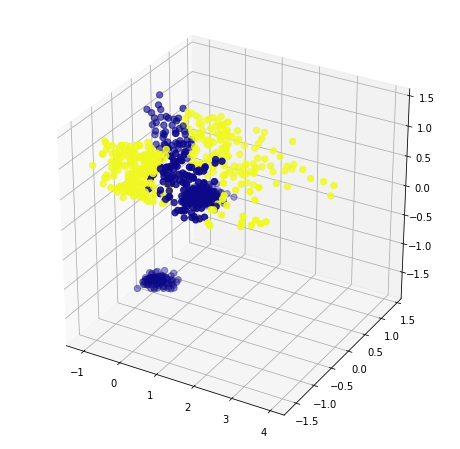

In [21]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.scatter(data['X3'], data['X2'], data['X1'], s=40, c=data['k'], cmap='plasma')
plt.show()

### Przedstawienie podziału average, k=7

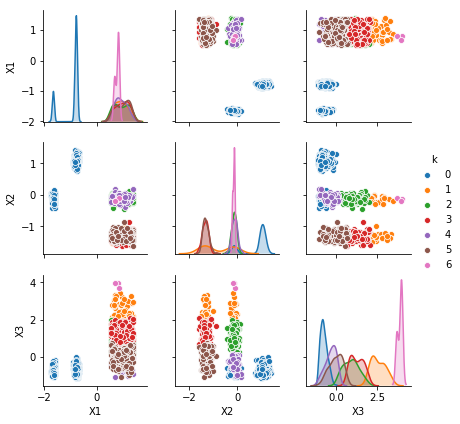

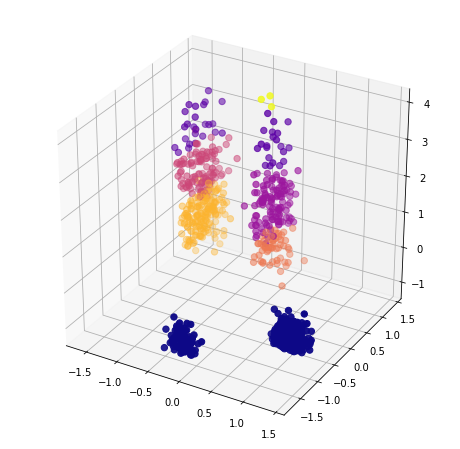

In [22]:
Agglomerative_plot(data,7,'average')

Ponownie, podział znacząco inny niż w poprzednich metodach.

### Przedstawienie podziału single, k=2

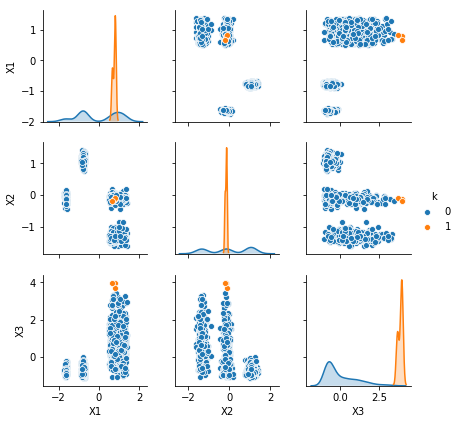

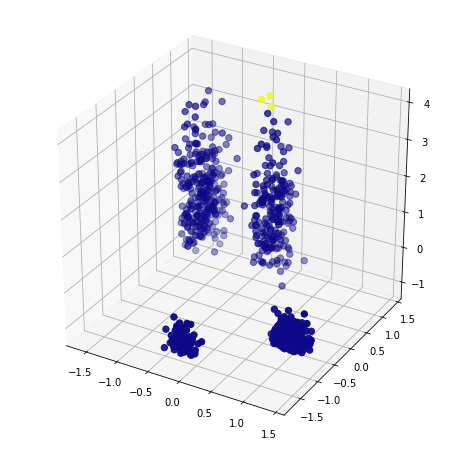

In [23]:
Agglomerative_plot(data,2,'single')

I kolejny dość niespodziewany podział na 2 klastry.

### Przedstawienie podziału single, k=3

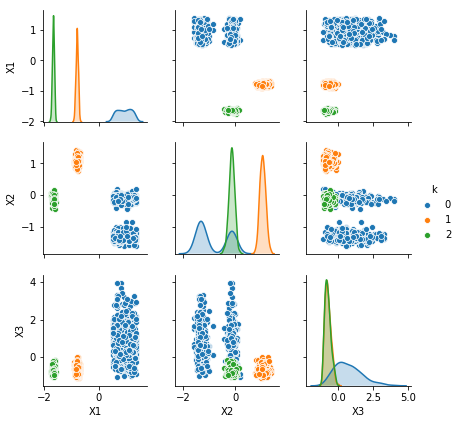

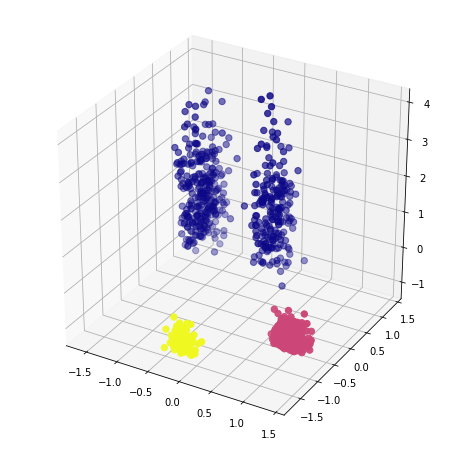

In [24]:
Agglomerative_plot(data,3,'single')

## Porównanie wyników

In [25]:
data=data.drop(columns=['k'])
wyniki = pd.DataFrame(np.array([[scores_ss1[0], scores_ss1[5],
    silhouette_score(data,AgglomerativeClustering(n_clusters=2,linkage='ward').fit_predict(data)),
    silhouette_score(data,AgglomerativeClustering(n_clusters=7,linkage='ward').fit_predict(data)),
    silhouette_score(data,AgglomerativeClustering(n_clusters=2,linkage='average').fit_predict(data)),
    silhouette_score(data,AgglomerativeClustering(n_clusters=7,linkage='average').fit_predict(data)),
    silhouette_score(data,AgglomerativeClustering(n_clusters=2,linkage='single').fit_predict(data)),
    silhouette_score(data,AgglomerativeClustering(n_clusters=3,linkage='single').fit_predict(data))
    ],
    [scores_db1[0], scores_ss1[5],
    davies_bouldin_score(data,AgglomerativeClustering(n_clusters=2,linkage='ward').fit_predict(data)),
    davies_bouldin_score(data,AgglomerativeClustering(n_clusters=7,linkage='ward').fit_predict(data)),
    davies_bouldin_score(data,AgglomerativeClustering(n_clusters=2,linkage='average').fit_predict(data)),
    davies_bouldin_score(data,AgglomerativeClustering(n_clusters=7,linkage='average').fit_predict(data)),
    davies_bouldin_score(data,AgglomerativeClustering(n_clusters=2,linkage='single').fit_predict(data)),
    davies_bouldin_score(data,AgglomerativeClustering(n_clusters=3,linkage='single').fit_predict(data))
    ],
    [scores_ch1[0], scores_ch1[5],
    calinski_harabaz_score(data,AgglomerativeClustering(n_clusters=2,linkage='ward').fit_predict(data)),
    calinski_harabaz_score(data,AgglomerativeClustering(n_clusters=7,linkage='ward').fit_predict(data)),
    calinski_harabaz_score(data,AgglomerativeClustering(n_clusters=2,linkage='average').fit_predict(data)),
    calinski_harabaz_score(data,AgglomerativeClustering(n_clusters=7,linkage='average').fit_predict(data)),
    calinski_harabaz_score(data,AgglomerativeClustering(n_clusters=2,linkage='single').fit_predict(data)),
    calinski_harabaz_score(data,AgglomerativeClustering(n_clusters=3,linkage='single').fit_predict(data))
    ]]),
    columns=['K-means(2)','K-means(7)',"Agglomerative ward(2)","Agglomerative ward(7)",
             "Agglomerative average(2)","Agglomerative average(7)","Agglomerative single(2)",
             "Agglomerative single(3)"],
    index=['Silhouette ↑','Davies-Bouldin ↓','Caliński-Harabasz ↑'])

wyniki

,K-means(2),K-means(7),Agglomerative ward(2),Agglomerative ward(7),Agglomerative average(2),Agglomerative average(7),Agglomerative single(2),Agglomerative single(3)
Silhouette ↑,0.653826,0.622284,0.653770,0.611266,0.653770,0.612198,0.653770,0.657175
Davies-Bouldin ↓,0.545201,0.622284,0.545305,0.635119,0.545305,0.633454,0.545305,0.424246
Caliński-Harabasz ↑,2446.611750,2874.758896,2442.315877,2724.619128,2442.315877,2661.794457,2442.315877,1654.511257


*Dla każdej metody zostały wybrane liczby klastrów (podane w nawiasach przy nazwie), które osiągały najlepsze wyniki miar. Przy każdej mierze mamy strzałeczkę podpowiadające nam czy lepsze są wartości mniejsze czy większe.*

- dla miary Silhouette najlepszy wynik osiągnęła metoda hierarchiczna z połączeniem single dla 3 klastrów. Jest to minimalna przewaga nad pozostałymi, także każda metoda osiąga tu bardzo podobny wynik.
- dla miary Daviesa-Bouldina najlepsze wartości osiąga ponownie metoda hierarchiczna z połączeniem single i 3 klastrami. Następne wyniki uzyskułą metody z podziałem na 2 klastry.
- dla miary Calińskiego-Harabasza obserwujemy najwyższą wartość dla K-means z 7 klastrami. Reszta przyjmuje zbliżone wartości, jedynie znacząco odstaje tu metoda hierarchiczna dla 3 klastrów.

Z powyższych miar optymalny okazuje się zatem wybór 3 lub 2 klastrów. Jeśli decydujemy się na 3, wybór metody jest oczywisty. Natomiast jeśli chodzi o 2 klastry, tutaj zarówno metody hierarchiczne jak i K-means uzyskują bardzo podobne wyniki.

Biorąc pod uwagę jednak wizualizacje zaproponowanych rozwiązań, widzimy znaczącą różnice chociażby w podziałach na 2 klastry. Jedne metody poradziły sobie z tym lepiej, jedne gorzej. Moim zdaniem najlepiej wypada podział na 3 klastry, podział na 2 lub 7 klastrów (k-means oraz ward). Niestety żadna z metod nie wskazała podziału na 4 klastry jako optymalnego podziału.

## Oświadczenie

Oświadczam, że niniejsza praca stanowiąca podstawę do uznania osiągnięcia efektów uczenia się z przedmiotu *Wstęp do uczenia maszynowego* została wykonana przeze mnie samodzielnie.

*Renata Rólkiewicz, 298840*